Titanic another file

In [12]:
%matplotlib inline
import torch
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('./train.csv', header = 0, dtype={'Age': np.float64})
test  = pd.read_csv('./test.csv' , header = 0, dtype={'Age': np.float64})
full_data = [train, test]

Feature Engineering

Here, credit must be extended to Sina's very comprehensive and well-thought out notebook for the feature engineering ideas so please check out his work

[Titanic Best Working Classfier : by Sina](https://www.kaggle.com/sinakhorami/titanic-best-working-classifier)

In [4]:
# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Feature engineering steps taken from Sina
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] 						        = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] 							        = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
dataset

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,892,3,"Kelly, Mr. James",1,2,0,0,330911,0,NaN,2,16,0,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,2,1,0,363272,0,NaN,0,32,0,2,0,3
2,894,2,"Myles, Mr. Thomas Francis",1,3,0,0,240276,1,NaN,2,25,0,1,1,1
3,895,3,"Wirz, Mr. Albert",1,1,0,0,315154,1,NaN,0,16,0,1,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,1,3101298,1,NaN,0,44,0,3,0,3
5,897,3,"Svensson, Mr. Johan Cervin",1,0,0,0,7538,1,NaN,0,26,0,1,1,1
6,898,3,"Connolly, Miss. Kate",0,1,0,0,330972,0,NaN,2,20,0,1,1,2
7,899,2,"Caldwell, Mr. Albert Francis",1,1,1,1,248738,2,NaN,0,28,0,3,0,1
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",0,1,0,0,2657,0,NaN,1,41,0,1,1,3
9,901,3,"Davies, Mr. John Samuel",1,1,2,0,A/4 48871,2,NaN,0,23,0,3,0,1


In [6]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [23]:
train.head()

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1


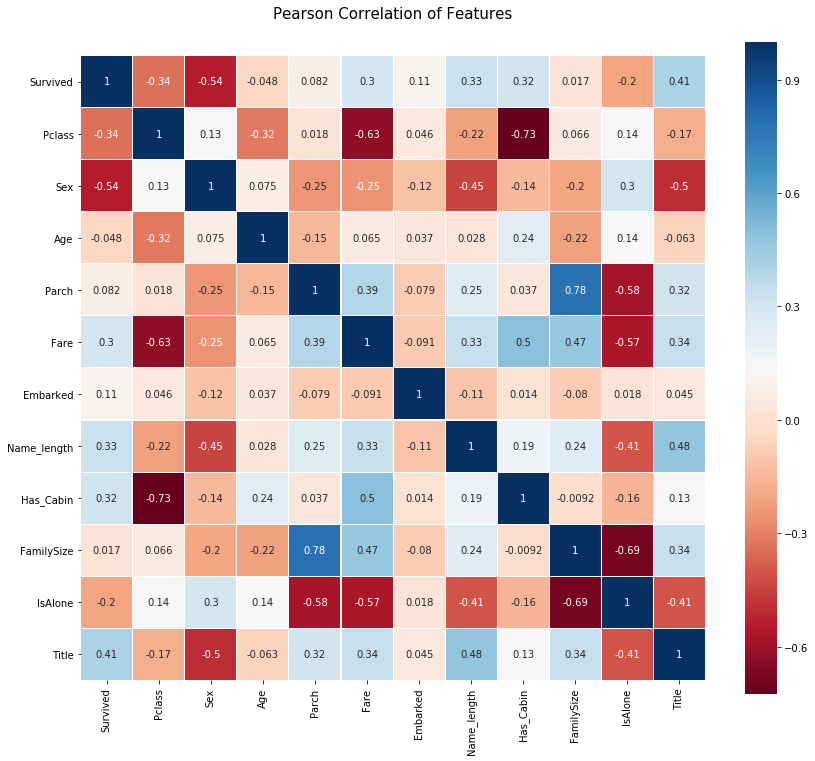

In [24]:
# Find correlation between feature
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)


In [25]:
class Model(torch.nn.Module):
    

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2
3,1,1,0,2,0,3,0,44,1,2,0,3
4,0,3,1,2,0,1,0,24,0,1,1,1
5,0,3,1,2,0,1,2,16,0,1,1,1
6,0,1,1,3,0,3,0,23,1,1,1,1
7,0,3,1,0,1,2,0,30,0,5,0,4
8,1,3,0,1,2,1,0,49,0,3,0,3
9,1,2,0,0,0,2,1,35,0,2,0,3
